# Assignment 5: Link Analysis

In this assignment, we will use network-based algorithms, such as PageRank, to improve our search results. After the last assignment on evaluating IR systems, we go back to our PubMed dataset of scientific papers. In this dataset, we look at two graphs in particular: the co-authorship network and the citation network.

The citation network is similar to the link network of the web: Citations are like web links pointing to other documents. We can therefore apply the same network-based ranking methods.

## Code from previous assignments

In [139]:
import pickle, bz2
from collections import defaultdict, namedtuple, Counter
from math import log10, sqrt
from IPython.display import display, HTML
import matplotlib.pyplot as plt

# show plots inline within the notebook
%matplotlib inline
# set plots' resolution
plt.rcParams['savefig.dpi'] = 100

In [140]:
Ids_file = 'data/emotion_Ids.pkl.bz2'
Summaries_file = 'data/emotion_Summaries.pkl.bz2'
Citations_file = 'data/emotion_Citations.pkl.bz2'
Abstracts_file = 'data/emotion_Abstracts.pkl.bz2'

Ids = pickle.load( bz2.BZ2File( Ids_file, 'rb' ) )
Summaries = pickle.load( bz2.BZ2File( Summaries_file, 'rb' ) )
Citations = pickle.load( bz2.BZ2File( Citations_file, 'rb' ) )
Abstracts = pickle.load( bz2.BZ2File( Abstracts_file, 'rb' ) )

paper = namedtuple( 'paper', ['title', 'authors', 'year', 'doi'] )

for (id, paper_info) in Summaries.items():
    Summaries[id] = paper( *paper_info )

In [141]:
def display_summary( id, show_abstract=False, show_id=True, extra_text='' ):
    """
    Function for printing a paper's summary through IPython's Rich Display System.
    Trims long author lists, and adds a link to the paper's DOI (when available).
    """
    s = Summaries[id]
    lines = []
    title = s.title
    if s.doi != '':
        title = '<a href=http://dx.doi.org/{:s}>{:s}</a>'.format(s.doi, title)
    title = '<strong>' + title + '</strong>'
    lines.append(title)
    authors = ', '.join( s.authors[:20] ) + ('' if len(s.authors) <= 20 else ', ...')
    lines.append(str(s.year) + '. ' + authors)
    if (show_abstract):
        lines.append('<small><strong>Abstract:</strong> <em>{:s}</em></small>'.format(Abstracts[id]))
    if (show_id):
        lines.append('[ID: {:d}]'.format(id))
    if (extra_text != ''):
         lines.append(extra_text)
    display( HTML('<br>'.join(lines)) )

In [142]:
def tokenize(text):
    return text.split(' ')

def preprocess(tokens):
    result = []
    for token in tokens:
        result.append(token.lower())
    return result

In [143]:
inverted_index = defaultdict(list)

for id in sorted(Summaries.keys()):
    term_set = set(preprocess(tokenize(Summaries[id].title)))
    if id in Abstracts:
        term_set.update(preprocess(tokenize(Abstracts[id])))
    for term in term_set:
        inverted_index[term].append(id)

tf_matrix = defaultdict(Counter)

for doc_id in Summaries.keys():
    tokens = preprocess(tokenize(Summaries[doc_id].title))
    if (doc_id in Abstracts):
        tokens.extend(preprocess(tokenize(Abstracts[doc_id])))
    tf_matrix[doc_id] = Counter(tokens)

def tf(t,d):
    return float(tf_matrix[d][t])

def df(t):
    return float(len(inverted_index[t]))

num_documents = float(len(Summaries))

def idf(t):
    return log10((num_documents + 1)/(df(t) + 1))

def tfidf(t,d):
    return tf(t,d) * idf(t)

## Co-authorship network

We start by building a mapping from authors to the set of identifiers of papers they authored.  We'll be using Python sets again for that purpose.

In [144]:
papers_of_author = defaultdict(set)

for (id, p) in Summaries.items():
    for a in p.authors:
        papers_of_author[a].add(id)

Let's try it out:

In [145]:
papers_of_author['Eriksen HR']

{9309949, 17760288, 31649584}

In [146]:
for id in papers_of_author['Eriksen HR']:
    display_summary(id)

We can now build a co-authorship network, that is a graph linking authors to the set of co-authors they have published with:

In [147]:
coauthors = defaultdict(set)

for p in Summaries.values():
    for a in p.authors:
        coauthors[a].update(p.authors)

# The code above results in each author being listed as having co-authored with himself/herself.
# We remove these self-references here:
for (a, ca) in coauthors.items():
    ca.remove(a)

And let's try it out again:

In [148]:
print(', '.join( coauthors['Eriksen HR'] ))

Johansen T, Lyby PS, Dittrich WH, Øyeflaten I, Orre IJ, Ursin H, Grant I, Palinkas LA, Jakobsen H, Suedfeld P, Svensen E, Holsen IN, Jensen C, Olff M, Marquis P


Unlike a citation or link network, the edges of this co-authorship network are not directed: There is no direction (no arrow) in the link between author 'Eriksen HR' and 'Suedfeld P', for example. With our chosen implementation, each of these links in fact appears twice in our data, as we also get 'Eriksen HR' as co-author when we look for 'Suedfeld P':

In [149]:
print(', '.join( coauthors['Suedfeld P'] ))

Orre IJ, Ursin H, Grant I, Palinkas LA, Eriksen HR, Svensen E, Marquis P


With that in mind, we can calculate some basic statistics about our graph:

In [150]:
print('Number of nodes (authors): ', len(coauthors))

# We divide by two here to account for the fact that each edge is represented twice (see above):
coauthor_rel_count = int(sum( len(c) for c in coauthors.values() ) / 2)
print('Number of links (co-authorship relations): ', coauthor_rel_count)

Number of nodes (authors):  99675
Number of links (co-authorship relations):  590848


With this data at hand, we can plot the [degree distribution](https://en.wikipedia.org/wiki/Degree_distribution) by showing the number of collaborators a scientist has published with:

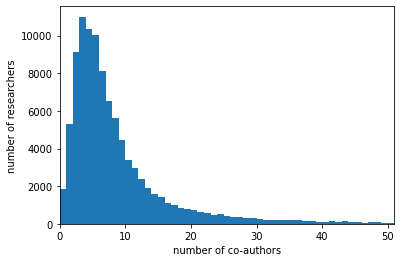

In [151]:
plt.hist( x=[ len(ca) for ca in coauthors.values() ], bins=range(60) )
plt.xlabel('number of co-authors')
plt.ylabel('number of researchers')
plt.xlim(0,51);

Now that we have explored this network, let's move to the citation network.

## Citations network

Next, we can look at the citation network. In contrast to the co-authorship network, the citation network is a _directed_ network, where edges can be drawn as arrows. We'll start by expanding the our data about citations into two mappings: 

* `papers_citing[id]`: papers citing a given paper
* `cited_by[id]`: papers cited by a given paper (in other words: its list of references)

`papers_citing` will give us the list of a node's incoming links, whereas `cited_by` will give us the list of its outgoing links.

In [152]:
papers_citing = Citations  # no changes needed, this is what we are storing already in the Citations dataset

cited_by = defaultdict(list)

for ref, papers_citing_ref in papers_citing.items():
    for id in papers_citing_ref:
        cited_by[ id ].append( ref )

As we are dealing with a subset of the data (the papers mentioning "emotion"), `papers_citing` can contain references to papers outside of our subset. On the other hand, the way we created `cited_by`, it will only contain backward references from within our dataset, meaning that it is incomplete with respect to the whole dataset. Nethertheless, we can use this citation network on our subset of emotion-related papers to implement link analysis techniques.

Let us now look at an exemplary paper, let's say the one with identifier 26784347. We can now use the `cited_by` mapping to retrieve its (incomplete) list of references:

In [153]:
paper_id = 26784347
refs = { id : Summaries[id].title for id in cited_by[paper_id] }
print(len(refs), 'references found for paper', paper_id)
refs

39 references found for paper 26784347


{24708508: 'Judgments of subtle facial expressions of emotion.',
 24388852: 'Dynamic facial expressions of emotion transmit an evolving hierarchy of signals over time.',
 23659578: 'Classification of dynamic facial expressions of emotion presented briefly.',
 22876223: 'Attention and awareness each influence amygdala activity for dynamic bodily expressions-a short review.',
 22131445: 'The resolution of facial expressions of emotion.',
 22081890: 'Introducing the Geneva Multimodal expression corpus for experimental research on emotion perception.',
 21859206: 'Moving faces, looking places: validation of the Amsterdam Dynamic Facial Expression Set (ADFES).',
 20809200: 'Facial emotion recognition in autism spectrum disorders: a review of behavioral and neuroimaging studies.',
 19884144: 'The face is not an empty canvas: how facial expressions interact with facial appearance.',
 19803591: 'Emotion recognition from expressions in face, voice, and body: the Multimodal Emotion Recognition T

If we lookup the same paper in `papers_citing`, we now see that some of the cited papers are themselves in our dataset, but others are not (shown below as `'??'`):

In [154]:
{ id : Summaries.get(id,['??'])[0]  for id in papers_citing[paper_id] }

{34138924: '??',
 33958630: 'The paradoxical role of emotional intensity in the perception of vocal affect.',
 33930026: 'SUST Bangla Emotional Speech Corpus (SUBESCO): An audio-only emotional speech corpus for Bangla.',
 33053797: 'Recognizing Emotions through Facial Expressions: A Largescale Experimental Study.',
 32804342: 'Human and machine validation of 14 databases of dynamic facial expressions.',
 32170180: 'Perception of Discrete Emotions in Others: Evidence for Distinct Facial Mimicry Patterns.',
 31762947: 'Are you angry at me? Negative interpretations of neutral facial expressions are linked to child maltreatment but not to posttraumatic stress disorder.',
 31258497: 'Development and Validation of Verbal Emotion Vignettes in Portuguese, English, and German.',
 30800085: '??',
 29928240: "Incongruence Between Observers' and Observed Facial Muscle Activation Reduces Recognition of Emotional Facial Expressions From Video Stimuli.",
 29370198: 'Gender differences in emotion perc

Paper 34138924, for example, is not in our dataset and we do not have any direct information about it, but its repeated occurrence in other papers' citation lists does allow us to reconstruct some of its references. Below is the list of papers in our dataset cited by that paper:

In [155]:
paper_id2 = 34138924
refs2 = { id : Summaries[id].title for id in cited_by[paper_id2] }
print(len(refs2), 'references identified for the paper with id', paper_id2)
refs2

20 references identified for the paper with id 34138924


{32804342: 'Human and machine validation of 14 databases of dynamic facial expressions.',
 31834900: 'The effect of emotional information from eyes on empathy for pain: A subliminal ERP study.',
 31622426: 'Assessing the convergent validity between the automated emotion recognition software Noldus FaceReader 7 and Facial Action Coding System Scoring.',
 30744534: "Validating the Radboud faces database from a child's perspective.",
 30589868: "Subjective ratings and emotional recognition of children's facial expressions from the CAFE set.",
 30273355: 'Cross-cultural emotion recognition and evaluation of Radboud faces database with an Indian sample.',
 29218587: 'Facial expression analysis with AFFDEX and FACET: A validation study.',
 28553255: 'Development of the Korean Facial Emotion Stimuli: Korea University Facial Expression Collection 2nd Edition.',
 26784347: 'Validation of the Amsterdam Dynamic Facial Expression Set--Bath Intensity Variations (ADFES-BIV): A Set of Videos Expressi

Now that we have a better understanding about the data we're dealing with, let us obtain again some basic statistics about our graph.

In [156]:
n = len(Ids)
print('Number of papers in our subset: {:d} ({:.2f} %)'.format(n, 100.0) )

with_citation = [ id for id in Ids if papers_citing[id] != [] ]
with_citation_rel = 100. * len(with_citation) / n
print('Number of papers cited at least once: {:d} ({:.2f} %)'.format(len(with_citation), with_citation_rel) )

isolated = set( id for id in Ids if papers_citing[id] == [] and id not in cited_by )
isolated_rel = 100. * len(isolated) / n
print('Number of isolated nodes:  {:d} ({:.2f} %)'.format(len(isolated), isolated_rel) )

Number of papers in our subset: 46483 (100.00 %)
Number of papers cited at least once: 35018 (75.34 %)
Number of isolated nodes:  8737 (18.80 %)


In [157]:
id_set = set( Ids )
citing_set = set( cited_by.keys() )

outsiders = citing_set - id_set   # set difference
nodes = citing_set | id_set   # set union
non_isolated = nodes - isolated   # set difference

print('Overall number of nodes: {:d} ({:.2f} %)'.format(len(nodes), 100.0) )

non_isolated_rel = 100. * len(non_isolated) / len(nodes)
print('Number of non-isolated nodes: {:d} ({:.2f} %)'.format(len(non_isolated), non_isolated_rel) )

outsiders_rel = 100. * len(outsiders) / len(nodes)
print('Number of nodes outside our subset: {:d} ({:.2f} %)'.format( len(outsiders), outsiders_rel ) )

Overall number of nodes: 221889 (100.00 %)
Number of non-isolated nodes: 213152 (96.06 %)
Number of nodes outside our subset: 175406 (79.05 %)


In [158]:
all_citations = [ c for citing in papers_citing.values() for c in citing ]
outsider_citations = [ c for citing in papers_citing.values() for c in citing if c in outsiders ]

print('Overall number of links (citations): {:d} ({:.2f} %)'.format(len(all_citations), 100.0) )

outsider_citations_rel = 100. * len(outsider_citations) / len(all_citations)
print('Citations outside the subset: {:d} ({:.2f} %)'.format(len(outsider_citations), outsider_citations_rel) )

Overall number of links (citations): 562891 (100.00 %)
Citations outside the subset: 401831 (71.39 %)


Let us now find our which 10 papers are the most cited in our dataset.

In [159]:
citation_count_per_paper = [ (id, len(citations)) for (id,citations) in papers_citing.items() ]
sorted_by_citation_count = sorted(citation_count_per_paper, key=lambda i:i[1], reverse=True)

for (id, c) in sorted_by_citation_count[:10]:
    display_summary(id, extra_text = 'Citation count: ' + str(c))

Before we can start calculating some interesting network metrics, we will first have a closer look at the Python package that we are going to use for that.

## Link Analysis for Search Engines

In order to use the citation network, we need to be able to perform some complex graph algorithms on it. To make our lives easier, we will use [NetworkX](https://pypi.python.org/pypi/networkx), a Python package for dealing with complex networks:

In [160]:
! pip install --user networkx

In [161]:
import networkx as nx

G = nx.DiGraph(cited_by)

We now have a NetworkX Directed Graph stored in `G`, where a node represents a paper, and an edge represents a citation. This means we can now apply the [algorithms](http://networkx.github.io/documentation/networkx-1.10/reference/algorithms.html) and [functions](http://networkx.github.io/documentation/networkx-1.10/reference/functions.html) of NetworkX to our graph:

In [162]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

DiGraph with 213152 nodes and 562891 edges
Directed graph: True
Density of graph: 1.2389321369843012e-05


As this graph was generated from citations only, we need to add all isolated nodes (nodes that are not cited and do not cite other papers) as well:

In [163]:
G.add_nodes_from(isolated)

And now we get slightly different values:

In [164]:
print(nx.info(G))
print('Directed graph:', nx.is_directed(G))
print('Density of graph:', nx.density(G))

DiGraph with 221889 nodes and 562891 edges
Directed graph: True
Density of graph: 1.1432855547712948e-05


Now we are ready to use this package for our tasks.

----------

# Tasks

**Your name:** Nikitas Filosofof

### Task 1

Plot the in-degree distribution (that is, the distribution of the number of incoming links; see [here](https://en.wikipedia.org/wiki/Degree_distribution) and [here](http://mathinsight.org/degree_distribution) for more detailed explanations) for the citation network. What can you tell about the shape of this distribution, and what does this tell us about the network?

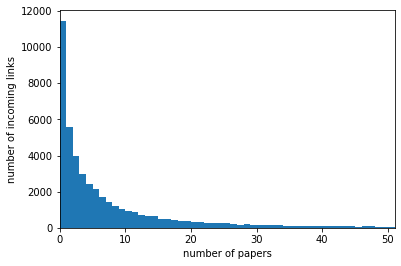

In [165]:
plt.hist( x=[ len(inc_links) for inc_links in papers_citing.values() ], bins=range(60) )
plt.xlabel('number of papers')
plt.ylabel('number of incoming links')
plt.xlim(0,51);

**Answer:** It's a very right-skewed histogram, and from it we can tell that most papers have no incoming links whatsoever	

### Task 2

Using the [Link Analysis](https://networkx.org/documentation/stable/reference/algorithms/link_analysis.html) algorithms provided by NetworkX, calculate the PageRank score for all nodes in the citation network, and store the result in a variable called `pageranks`.

To test this, create first a list of all papers that are cited by exactly 10 other papers (using `papers_citing` defined above). Then sort these papers by their PageRank and retrieve the paper IDs with the maximum and minimum PageRank values. Print these minimum and maximum PageRank values together with their paper IDs.

To print PageRank values, you might want to use commands like `print('{:.6f}'.format(var))` to use regular decimal notation with a fixed number of decimal places.

In [166]:
# Add your code here
pageranks = nx.link_analysis.pagerank(G)

In [167]:
papers_10_incoming = [id for id, inc_links in papers_citing.items() if len(inc_links) ==10]

ranked = {}
for paper in papers_10_incoming:
	ranked[paper] = pageranks[paper]

ranked = sorted(ranked.items(), key=lambda x: x[1], reverse=True)

print("Maximum value is: ", '{:.10f}'.format(ranked[0][1]), "from document: ", ranked[0][0])
print("Minimum value is: ", '{:.10f}'.format(ranked[-1][1]), "from document: ", ranked[-1][0])



Maximum value is:  0.0000379816 from document:  12382205
Minimum value is:  0.0000030449 from document:  28402574


### Task 3

Why do the two papers above have such different PageRank values? Write code below to investigate and show the cause of this, and then explain the cause of this difference based on the results generated by your code.

In [168]:
#First i'll investigate their incoming links
links_to_max = papers_citing[12382205]
links_to_min = papers_citing[28402574]
print(len(links_to_max), len(links_to_min))
#Turns out they have the same number of links
#I just realized that's because the whole subset is with papers with the same number of links

#I'll check the average pagerank of their incoming links
max_authority = 0
for doc in links_to_max:
	max_authority += pageranks[doc]

min_authority = 0
for doc in links_to_min:
	min_authority += pageranks[doc]

print(max_authority/10, min_authority/10)
#Aha! The average rank of the document linking to the maximum one, are way more important than the ones pointing to the min. 

10 10
9.517480542279814e-06 3.3997988956590496e-06


**Answer:** The average rank of the documents linking to the maximum one are way more important than the ones pointing to the min. 

### Task 4

Copy the scoring function `score_ntn_nnn` from Task 4 of assignment 3. Rename it to `score_ntn_nnn_pagerank` and change its code to incorporate a paper's PageRank score in it's final score, in addition to tf-idf. In other words, the new function should accept a `list` of query tokens and a document ID, and should return a single `float` value that is calculated based on both scores (PageRank and tf-idf). Note that a `tf-idf` function is already provided above. Explain your decision on how to combine the two scores.

In [169]:
def score_ntn_nnn_pagerank(query_words, doc_id):
	result = 0

	for term in query_words:
		result += tfidf(term, doc_id)

	return result * pageranks[doc_id]

print(score_ntn_nnn_pagerank(['emotion', 'women'], 22571249))

0.00013447693490362437


**Answer:** Page rank is an paper authority measure thus it should act as a moderator of the ranking. Multipling the a paper's rank by it's ntn.nnn score gives us the most important documents from those that are most relevant to a given topic.

### Task 5

Copy the query function `query_ntn_nnn` from Task 4 of assignment 3 (also copy `or_merge`). Rename it to `query_ntn_nnn_pagerank` and change the code to use our new scoring function `score_ntn_nnn_pagerank` from task 4 above. Demonstrate these functions with an example query that returns paper 16242399 as the top result.

In [170]:
def or_merge(sorted_list1, sorted_list2):
    merged_list = []
    list1 = list(sorted_list1)
    list2 = list(sorted_list2)
    while (True):
        if (not list1):
            merged_list.extend(list2)
            break
        if (not list2):
            merged_list.extend(list1)
            break
        if (list1[0] < list2[0]):
            merged_list.append(list1[0])
            list1.pop(0)
        elif (list1[0] > list2[0]):
            merged_list.append(list2[0])
            list2.pop(0)
        else:
            merged_list.append(list1[0])
            list1.pop(0)
            list2.pop(0)
    return merged_list

def or_query(query_string):
    query_words = preprocess(tokenize(query_string))
    first_word = query_words[0]
    remaining_words = query_words[1:]
    or_list = inverted_index[first_word]
    for t in remaining_words:
        or_list = or_merge(or_list, inverted_index[t])
    return or_list

def query_ntn_nnn_pagerank(query_string):
	docs = or_query(query_string)
	terms = preprocess(tokenize(query_string))
	doc_weights = defaultdict(set)
	for doc_id in docs:
		doc_weights[doc_id] = score_ntn_nnn_pagerank(terms, doc_id)	

	return dict(sorted(doc_weights.items(), key=lambda x:x[1],reverse=True)[0:10])

In [171]:
query_ntn_nnn_pagerank('amygdala emotional processing activates')

{16242399: 0.0061094140346399884,
 12505650: 0.00589270329832829,
 10377356: 0.005532961342110747,
 11244481: 0.005471414297617973,
 16624961: 0.004554925524024069,
 8893004: 0.004527062007258105,
 15880108: 0.003615265613848397,
 10845062: 0.003504411683416224,
 12453496: 0.0029549853185168702,
 10827444: 0.002866964093239108}

# Submission

Submit the answers to the assignment via Canvas as a modified version of this Notebook file (file with `.ipynb` extension) that includes your code and your answers.

Before submitting, restart the kernel and re-run the complete code (**Kernel > Restart & Run All**), and then check whether your assignment code still works as expected.

Don't forget to add your name, and remember that the assignments have to be done **individually**, and that code sharing or copying are **strictly forbidden** and will be punished.